# ``ScipyOptimizer`` Tutorial

This tutorial demonstrates how to use the `ScipyOptimizer` from BrainTools for gradient-based optimization. The ScipyOptimizer provides a convenient wrapper around SciPy's optimization methods with automatic differentiation via JAX, support for complex parameter structures, and seamless integration with BrainUnit quantities.

## Introduction and Setup

The `ScipyOptimizer` is designed for gradient-based optimization where derivatives can be computed automatically via JAX. It's particularly useful for:
- Smooth, differentiable objective functions
- Neural network parameter optimization
- Physics-based models with analytical gradients
- Problems where gradient information is reliable

Key advantages over derivative-free methods:
- **Faster convergence** for smooth problems
- **Higher precision** solutions
- **Automatic gradients** via JAX
- **Mature algorithms** from SciPy

Let's start by importing the necessary libraries:

In [1]:
# Core imports
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import OptimizeResult

# BrainTools imports
import braintools as bts
import brainunit as u
import brainstate as bst

# Set up plotting
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

print("BrainTools version:", bts.__version__)
print("JAX version:", jax.__version__)

BrainTools version: 0.0.12
JAX version: 0.7.1


First, let's check if SciPy is installed (it's required for the optimizer to work):

In [2]:
try:
    import scipy
    from scipy.optimize import minimize
    print(f"SciPy version: {scipy.__version__}")
    print("✓ SciPy is available")
except ImportError:
    print("❌ SciPy is not installed. Please install it with:")
    print("   pip install scipy")
    raise

SciPy version: 1.14.1
✓ SciPy is available


## Basic Usage: Scalar Parameters

Let's start with a simple example: optimizing a quadratic function with two scalar parameters.

In [3]:
# Define a simple quadratic loss function
def quadratic_loss(x, y):
    """
    Simple quadratic function with known minimum at (2, -1).
    
    Args:
        x, y: Scalar parameters
        
    Returns:
        Scalar loss value
    """
    return (x - 2.0)**2 + (y + 1.0)**2

# Define bounds for each parameter: (min, max)
bounds = [
    (-5.0, 5.0),  # bounds for x
    (-3.0, 3.0),  # bounds for y
]

# Create the optimizer
optimizer = bts.optim.ScipyOptimizer(
    loss_fun=quadratic_loss,
    bounds=bounds,
    method='L-BFGS-B'  # Limited-memory BFGS with bounds
)

print("Optimizer created successfully!")
print(f"Method: {optimizer.method}")
print(f"Bounds structure: {type(bounds).__name__}")

Optimizer created successfully!
Method: L-BFGS-B
Bounds structure: list


In [4]:
# Run the optimization
result = optimizer.minimize(n_iter=3)  # Try 3 random starting points

print(f"\nOptimization completed!")
print(f"Success: {result.success}")
print(f"Message: {result.message}")
print(f"Optimal parameters: x={result.x[0]:.6f}, y={result.x[1]:.6f}")
print(f"True optimum: x=2.0, y=-1.0")
print(f"Final loss: {result.fun:.10f}")
print(f"Function evaluations: {result.nfev}")
print(f"Gradient evaluations: {result.njev}")


Optimization completed!
Success: True
Message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Optimal parameters: x=2.000000, y=-1.000000
True optimum: x=2.0, y=-1.0
Final loss: 0.0000000000
Function evaluations: 4
Gradient evaluations: 4


C:\Users\adadu\AppData\Local\Temp\ipykernel_59268\1560779676.py:28: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax2.set_yscale('log')


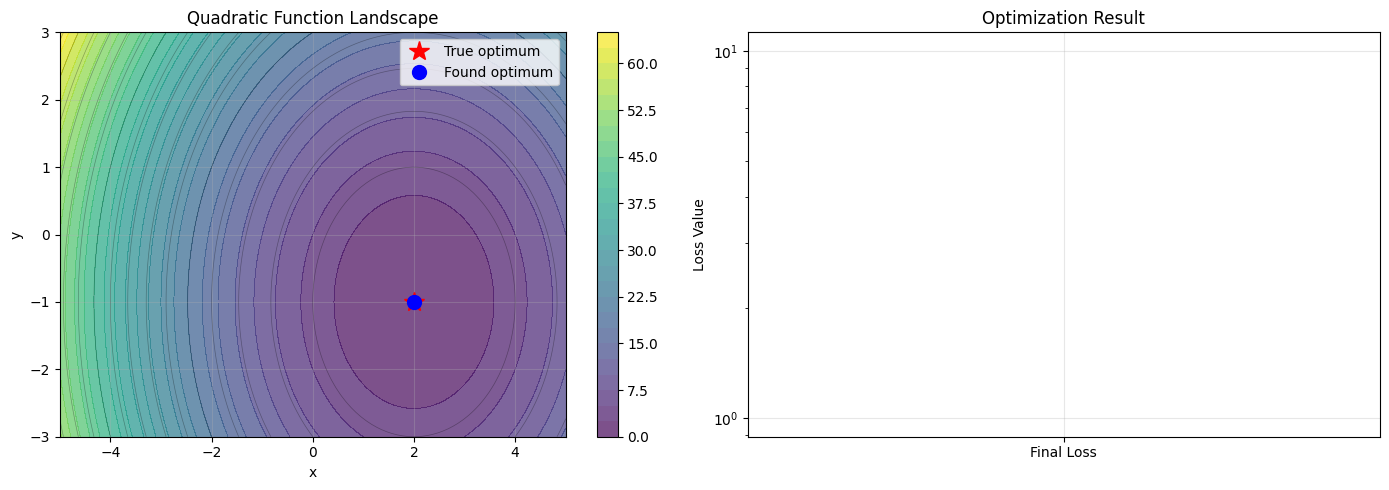

Distance from true optimum: 0.00e+00


In [5]:
# Visualize the optimization landscape and result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot the function landscape
x_range = np.linspace(-5, 5, 100)
y_range = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = (X - 2.0)**2 + (Y + 1.0)**2

contour = ax1.contourf(X, Y, Z, levels=30, cmap='viridis', alpha=0.7)
ax1.contour(X, Y, Z, levels=20, colors='black', alpha=0.3, linewidths=0.5)
plt.colorbar(contour, ax=ax1)

# Mark the true optimum and found optimum
ax1.plot(2.0, -1.0, 'r*', markersize=15, label='True optimum')
ax1.plot(result.x[0], result.x[1], 'bo', markersize=10, label='Found optimum')

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Quadratic Function Landscape')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Show convergence (we don't have iteration history, so show final result)
ax2.bar(['Final Loss'], [result.fun], color='blue', alpha=0.7)
ax2.set_ylabel('Loss Value')
ax2.set_title('Optimization Result')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Distance from true optimum: {np.sqrt((result.x[0] - 2.0)**2 + (result.x[1] + 1.0)**2):.2e}")

## Multi-dimensional Array Parameters

The ScipyOptimizer can handle multi-dimensional arrays as parameters. Let's optimize a function that takes matrix parameters.

In [6]:
# Define a loss function with matrix parameters
def matrix_frobenius_loss(W, b):
    """
    Find matrix W and vector b that minimize Frobenius norm from targets.
    
    Args:
        W: Matrix parameter of shape (3, 2)
        b: Vector parameter of shape (2,)
        
    Returns:
        Scalar loss (Frobenius norm squared)
    """
    W_target = jnp.array([[1.0, -0.5], [0.3, 1.2], [-0.8, 0.9]])
    b_target = jnp.array([0.1, -0.3])
    
    W_diff = W - W_target
    b_diff = b - b_target
    
    return jnp.sum(W_diff**2) + jnp.sum(b_diff**2)

# Define bounds for array parameters
bounds = [
    (jnp.full((3, 2), -2.0), jnp.full((3, 2), 2.0)),  # bounds for W (3x2 matrix)
    (jnp.full(2, -1.0), jnp.full(2, 1.0)),            # bounds for b (2D vector)
]

# Create optimizer
matrix_optimizer = bts.optim.ScipyOptimizer(
    loss_fun=matrix_frobenius_loss,
    bounds=bounds,
    method='L-BFGS-B'  # Good for smooth, bounded problems
)

print("Multi-dimensional optimizer created!")
print(f"W parameter shape: {bounds[0][0].shape}")
print(f"b parameter shape: {bounds[1][0].shape}")

Multi-dimensional optimizer created!
W parameter shape: (3, 2)
b parameter shape: (2,)


In [7]:
# Run optimization
matrix_result = matrix_optimizer.minimize(n_iter=5)

W_best, b_best = matrix_result.x
print(f"\nOptimization completed!")
print(f"Success: {matrix_result.success}")
print(f"Function evaluations: {matrix_result.nfev}")

print(f"\nOptimal W matrix:")
print(W_best)
print(f"\nOptimal b vector:")
print(b_best)

# Compare with targets
W_target = jnp.array([[1.0, -0.5], [0.3, 1.2], [-0.8, 0.9]])
b_target = jnp.array([0.1, -0.3])
print(f"\nTarget W matrix:")
print(W_target)
print(f"\nTarget b vector:")
print(b_target)

print(f"\nFinal loss: {matrix_result.fun:.10f}")
print(f"W error (Frobenius): {jnp.linalg.norm(W_best - W_target):.2e}")
print(f"b error (L2): {jnp.linalg.norm(b_best - b_target):.2e}")


Optimization completed!
Success: True
Function evaluations: 3

Optimal W matrix:
[[ 1.  -0.5]
 [ 0.3  1.2]
 [-0.8  0.9]]

Optimal b vector:
[ 0.10000002 -0.3       ]

Target W matrix:
[[ 1.  -0.5]
 [ 0.3  1.2]
 [-0.8  0.9]]

Target b vector:
[ 0.1 -0.3]

Final loss: 0.0000000000
W error (Frobenius): 0.00e+00
b error (L2): 2.24e-08


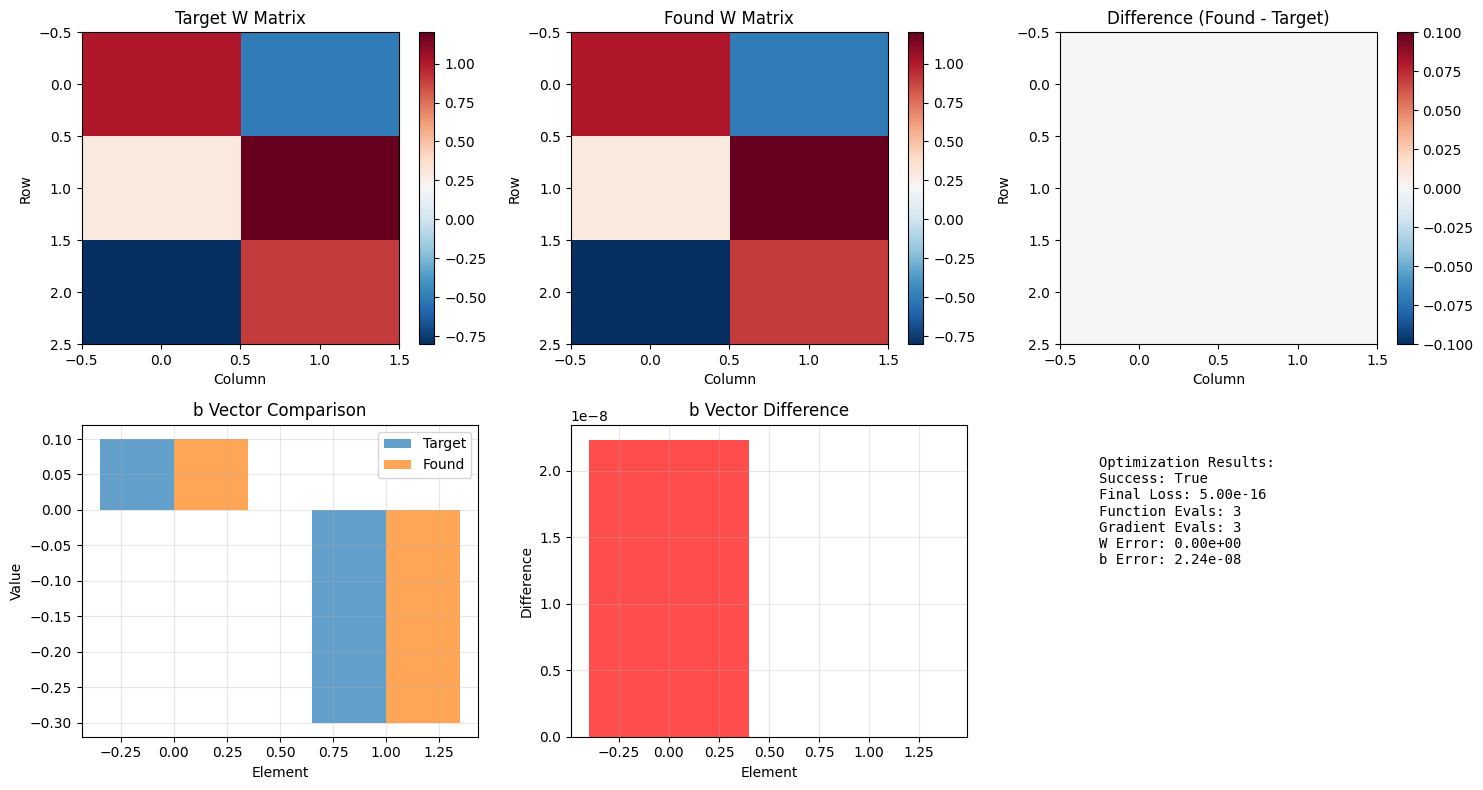

In [8]:
# Visualize the matrix optimization results
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Plot W matrix: target, found, and difference
im1 = axes[0, 0].imshow(W_target, cmap='RdBu_r', aspect='auto')
axes[0, 0].set_title('Target W Matrix')
axes[0, 0].set_xlabel('Column')
axes[0, 0].set_ylabel('Row')
plt.colorbar(im1, ax=axes[0, 0])

im2 = axes[0, 1].imshow(W_best, cmap='RdBu_r', aspect='auto')
axes[0, 1].set_title('Found W Matrix')
axes[0, 1].set_xlabel('Column')
axes[0, 1].set_ylabel('Row')
plt.colorbar(im2, ax=axes[0, 1])

W_diff = W_best - W_target
im3 = axes[0, 2].imshow(W_diff, cmap='RdBu_r', aspect='auto')
axes[0, 2].set_title('Difference (Found - Target)')
axes[0, 2].set_xlabel('Column')
axes[0, 2].set_ylabel('Row')
plt.colorbar(im3, ax=axes[0, 2])

# Plot b vector: target, found, and difference
x_pos = np.arange(len(b_target))
width = 0.35

axes[1, 0].bar(x_pos - width/2, b_target, width, label='Target', alpha=0.7)
axes[1, 0].bar(x_pos + width/2, b_best, width, label='Found', alpha=0.7)
axes[1, 0].set_xlabel('Element')
axes[1, 0].set_ylabel('Value')
axes[1, 0].set_title('b Vector Comparison')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot the difference in b
b_diff = b_best - b_target
axes[1, 1].bar(x_pos, b_diff, alpha=0.7, color='red')
axes[1, 1].set_xlabel('Element')
axes[1, 1].set_ylabel('Difference')
axes[1, 1].set_title('b Vector Difference')
axes[1, 1].grid(True, alpha=0.3)

# Plot optimization info
info_text = f"""Optimization Results:
Success: {matrix_result.success}
Final Loss: {matrix_result.fun:.2e}
Function Evals: {matrix_result.nfev}
Gradient Evals: {matrix_result.njev}
W Error: {jnp.linalg.norm(W_diff):.2e}
b Error: {jnp.linalg.norm(b_diff):.2e}"""

axes[1, 2].text(0.1, 0.9, info_text, transform=axes[1, 2].transAxes, 
                verticalalignment='top', fontsize=10, fontfamily='monospace')
axes[1, 2].set_xlim(0, 1)
axes[1, 2].set_ylim(0, 1)
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## Named Parameters with Dictionary Bounds

For better organization, especially with many parameters, you can use dictionary bounds to give meaningful names to your parameters.

In [9]:
# Define a loss function that accepts named parameters
def rosenbrock_loss(**params):
    """
    The famous Rosenbrock function with named parameters.
    Global minimum at x=1, y=1 with value 0.
    
    Args:
        **params: Dictionary with keys 'x' and 'y'
        
    Returns:
        Scalar loss value
    """
    x, y = params['x'], params['y']
    a, b = 1.0, 100.0
    return (a - x)**2 + b * (y - x**2)**2

# Define named bounds
named_bounds = {
    'x': (-2.0, 2.0),
    'y': (-1.0, 3.0)
}

# Create optimizer with named parameters
named_optimizer = bts.optim.ScipyOptimizer(
    loss_fun=rosenbrock_loss,
    bounds=named_bounds,
    method='L-BFGS-B'
)

print("Named parameter optimizer created!")
print(f"Parameters: {list(named_bounds.keys())}")

Named parameter optimizer created!
Parameters: ['x', 'y']


In [10]:
# Run optimization
named_result = named_optimizer.minimize(n_iter=5)

print(f"\nOptimization completed!")
print(f"Success: {named_result.success}")
print(f"Function evaluations: {named_result.nfev}")
print(f"Gradient evaluations: {named_result.njev}")

print(f"\nOptimal parameters:")
for param_name, value in named_result.x.items():
    print(f"  {param_name}: {value:.6f}")

print(f"\nTrue optimal values:")
print(f"  x: 1.000000")
print(f"  y: 1.000000")

print(f"\nFinal loss: {named_result.fun:.10f}")
print(f"Distance from optimum: {np.sqrt((named_result.x['x'] - 1.0)**2 + (named_result.x['y'] - 1.0)**2):.2e}")


Optimization completed!
Success: True
Function evaluations: 30
Gradient evaluations: 30

Optimal parameters:
  x: 1.000000
  y: 1.000000

True optimal values:
  x: 1.000000
  y: 1.000000

Final loss: 0.0000000000
Distance from optimum: 2.67e-07


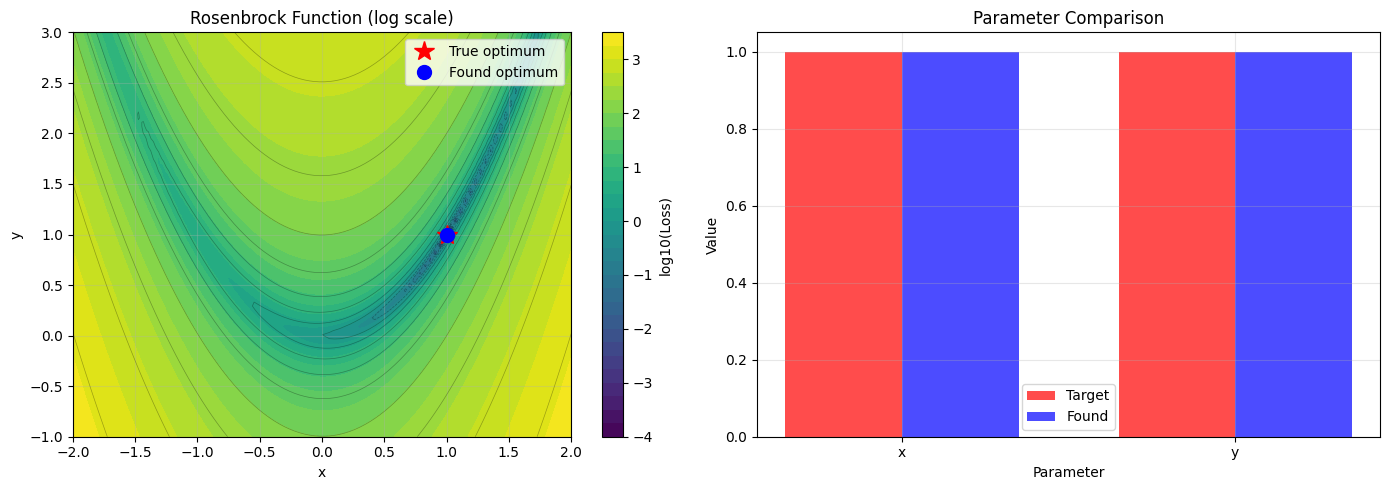

In [11]:
# Visualize the Rosenbrock function and optimization result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot the Rosenbrock function landscape
x_range = np.linspace(-2, 2, 100)
y_range = np.linspace(-1, 3, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = (1 - X)**2 + 100 * (Y - X**2)**2

# Use log scale for better visualization
Z_log = np.log10(Z + 1e-10)
contour = ax1.contourf(X, Y, Z_log, levels=30, cmap='viridis')
ax1.contour(X, Y, Z_log, levels=20, colors='black', alpha=0.3, linewidths=0.5)
plt.colorbar(contour, ax=ax1, label='log10(Loss)')

# Mark the true optimum and found optimum
ax1.plot(1.0, 1.0, 'r*', markersize=15, label='True optimum')
ax1.plot(named_result.x['x'], named_result.x['y'], 'bo', markersize=10, label='Found optimum')

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Rosenbrock Function (log scale)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot parameter values
param_names = list(named_result.x.keys())
param_values = [named_result.x[name] for name in param_names]
target_values = [1.0, 1.0]

x_pos = np.arange(len(param_names))
width = 0.35

ax2.bar(x_pos - width/2, target_values, width, label='Target', alpha=0.7, color='red')
ax2.bar(x_pos + width/2, param_values, width, label='Found', alpha=0.7, color='blue')

ax2.set_xlabel('Parameter')
ax2.set_ylabel('Value')
ax2.set_title('Parameter Comparison')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(param_names)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Working with BrainUnit Quantities

The ScipyOptimizer seamlessly integrates with BrainUnit quantities, allowing you to optimize parameters with physical units.

In [12]:
# Define a loss function for neuron model parameters with units
def neuron_model_loss(tau_m, V_th, V_reset, I_ext):
    """
    Loss function for fitting a neuron model to target parameters.
    
    Args:
        tau_m: Membrane time constant (scalar)
        V_th: Threshold voltage (scalar)
        V_reset: Reset voltage (scalar)
        I_ext: External current (scalar)
        
    Returns:
        Scalar loss representing deviation from target behavior
    """
    # Target values (without units - optimizer handles unit conversion)
    tau_target = 20.0    # ms
    V_th_target = -50.0  # mV
    V_reset_target = -70.0  # mV
    I_target = 100.0     # pA
    
    # Compute normalized squared differences
    tau_loss = ((tau_m - tau_target) / 10.0)**2
    V_th_loss = ((V_th - V_th_target) / 10.0)**2
    V_reset_loss = ((V_reset - V_reset_target) / 10.0)**2
    I_loss = ((I_ext - I_target) / 50.0)**2
    
    return tau_loss + V_th_loss + V_reset_loss + I_loss

# Define bounds with units
unit_bounds = {
    'tau_m': (5.0 * u.ms, 50.0 * u.ms),
    'V_th': (-80.0 * u.mV, -30.0 * u.mV),
    'V_reset': (-90.0 * u.mV, -60.0 * u.mV),
    'I_ext': (10.0 * u.pA, 200.0 * u.pA)
}

# Create optimizer
unit_optimizer = bts.optim.ScipyOptimizer(
    loss_fun=neuron_model_loss,
    bounds=unit_bounds,
    method='L-BFGS-B'
)

print("Neuron parameter optimizer with units created!")
for name, (low, high) in unit_bounds.items():
    print(f"  {name}: {low} to {high}")

Neuron parameter optimizer with units created!
  tau_m: 5.0 * msecond to 50.0 * msecond
  V_th: -80.0 * mvolt to -30.0 * mvolt
  V_reset: -90.0 * mvolt to -60.0 * mvolt
  I_ext: 10.0 * pamp to 200.0 * pamp


In [13]:
# Run optimization with units
unit_result = unit_optimizer.minimize(n_iter=3)

print(f"\nOptimization completed!")
print(f"Success: {unit_result.success}")
print(f"Function evaluations: {unit_result.nfev}")

print(f"\nOptimal neuron parameters:")
for param_name, value in unit_result.x.items():
    print(f"  {param_name}: {value:.6f}")

print(f"\nTarget parameters:")
print(f"  tau_m: 20.0")
print(f"  V_th: -50.0")
print(f"  V_reset: -70.0")
print(f"  I_ext: 100.0")

print(f"\nFinal loss: {unit_result.fun:.10f}")

# Note: The optimizer works with dimensionless values internally
# but maintains the parameter structure


Optimization completed!
Success: True
Function evaluations: 9

Optimal neuron parameters:
  I_ext: 100.000000
  V_reset: -70.000000
  V_th: -50.000000
  tau_m: 20.000000

Target parameters:
  tau_m: 20.0
  V_th: -50.0
  V_reset: -70.0
  I_ext: 100.0

Final loss: 0.0000000000


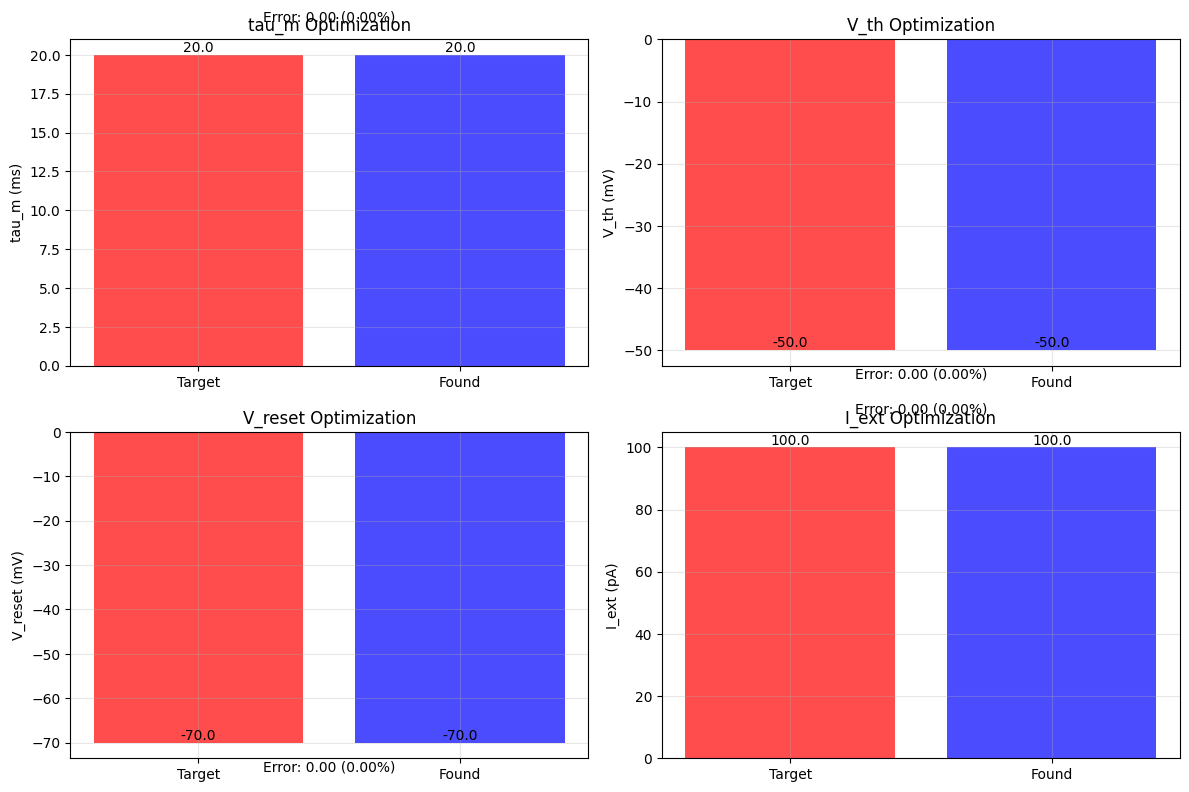


Parameter Errors:
  tau_m: 0.000 ms (0.00%)
  V_th: 0.000 mV (0.00%)
  V_reset: 0.000 mV (0.00%)
  I_ext: 0.000 pA (0.00%)


In [14]:
# Visualize neuron parameter optimization results
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

# Define target values and units for visualization
targets = {
    'tau_m': (20.0, 'ms'),
    'V_th': (-50.0, 'mV'),
    'V_reset': (-70.0, 'mV'),
    'I_ext': (100.0, 'pA')
}

for i, (param_name, (target_val, unit)) in enumerate(targets.items()):
    found_val = unit_result.x[param_name]
    
    # Plot comparison
    axes[i].bar(['Target', 'Found'], [target_val, found_val], 
               color=['red', 'blue'], alpha=0.7)
    axes[i].set_ylabel(f'{param_name} ({unit})')
    axes[i].set_title(f'{param_name} Optimization')
    axes[i].grid(True, alpha=0.3)
    
    # Add value labels on bars
    axes[i].text(0, target_val, f'{target_val:.1f}', ha='center', va='bottom')
    axes[i].text(1, found_val, f'{found_val:.1f}', ha='center', va='bottom')
    
    # Add error information
    error = abs(found_val - target_val)
    rel_error = error / abs(target_val) * 100
    axes[i].text(0.5, max(target_val, found_val) * 1.1, 
                f'Error: {error:.2f} ({rel_error:.2f}%)', 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print("\nParameter Errors:")
for param_name, (target_val, unit) in targets.items():
    found_val = unit_result.x[param_name]
    error = abs(found_val - target_val)
    rel_error = error / abs(target_val) * 100
    print(f"  {param_name}: {error:.3f} {unit} ({rel_error:.2f}%)")

## Different SciPy Methods

SciPy provides many optimization algorithms. Let's compare several of them on the same problem.

In [16]:
# Define a more challenging test function
def beale_function(x, y):
    """
    Beale function - a challenging optimization benchmark.
    Global minimum at (3, 0.5) with value 0.
    """
    return ((1.5 - x + x*y)**2 + 
            (2.25 - x + x*y**2)**2 + 
            (2.625 - x + x*y**3)**2)

bounds = [(-4.5, 4.5), (-4.5, 4.5)]

# Test different SciPy methods
methods = [
    'L-BFGS-B',    # Limited memory BFGS with bounds
    # 'TNC',         # Truncated Newton with bounds
    'SLSQP',       # Sequential Least Squares Programming
    'Powell',      # Powell's method (derivative-free but included for comparison)
]

results = {}

print("Testing different SciPy optimization methods...\n")

for method in methods:
    print(f"Testing {method}...")
    
    optimizer = bts.optim.ScipyOptimizer(
        loss_fun=beale_function,
        bounds=bounds,
        method=method
    )
    
    result = optimizer.minimize(n_iter=3)
    
    results[method] = {
        'result': result,
        'success': result.success,
        'final_loss': result.fun,
        'nfev': result.nfev,
        'njev': getattr(result, 'njev', 0),
        'params': result.x
    }
    
    print(f"  Success: {result.success}")
    print(f"  Final loss: {result.fun:.8f}")
    print(f"  Parameters: ({result.x[0]:.4f}, {result.x[1]:.4f})")
    print(f"  Function evaluations: {result.nfev}")
    if hasattr(result, 'njev'):
        print(f"  Gradient evaluations: {result.njev}")
    print()

print("Method comparison completed!")
print(f"\nTrue optimum: (3.0, 0.5) with loss = 0.0")

Testing different SciPy optimization methods...

Testing L-BFGS-B...
  Success: True
  Final loss: 0.00000000
  Parameters: (3.0000, 0.5000)
  Function evaluations: 21
  Gradient evaluations: 21

Testing SLSQP...
  Success: True
  Final loss: 0.00000011
  Parameters: (2.9992, 0.4998)
  Function evaluations: 42
  Gradient evaluations: 33

Testing Powell...


D:\codes\projects\braintools\braintools\optim\_scipy_optimizer.py:286: RuntimeWarning: Method Powell does not use gradient information (jac).
  results = minimize(


  Success: True
  Final loss: 0.00000000
  Parameters: (3.0000, 0.5000)
  Function evaluations: 483

Method comparison completed!

True optimum: (3.0, 0.5) with loss = 0.0


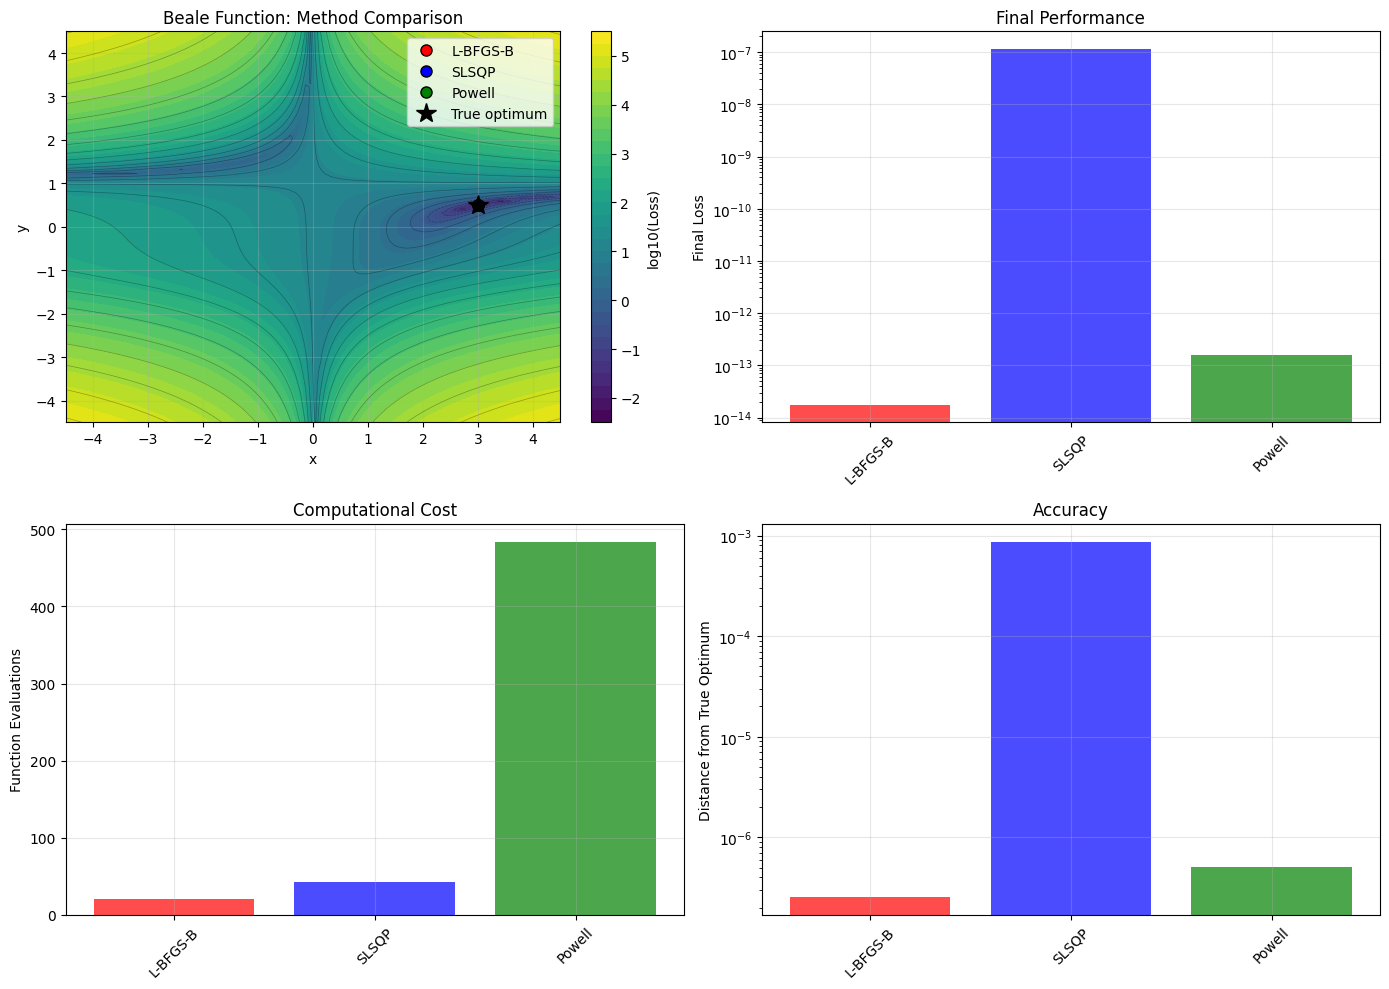


Method Performance Summary:
Method		Success	Final Loss	Func Evals	Distance
-----------------------------------------------------------------
L-BFGS-B    	True	1.78e-14	  21		2.55e-07
SLSQP       	True	1.15e-07	  42		8.72e-04
Powell      	True	1.60e-13	 483		5.09e-07


In [17]:
# Visualize method comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot the Beale function landscape
x_range = np.linspace(-4.5, 4.5, 100)
y_range = np.linspace(-4.5, 4.5, 100)
X, Y = np.meshgrid(x_range, y_range)
Z = ((1.5 - X + X*Y)**2 + 
     (2.25 - X + X*Y**2)**2 + 
     (2.625 - X + X*Y**3)**2)

# Use log scale for better visualization
Z_log = np.log10(Z + 1e-10)
contour = axes[0, 0].contourf(X, Y, Z_log, levels=30, cmap='viridis')
axes[0, 0].contour(X, Y, Z_log, levels=20, colors='black', alpha=0.3, linewidths=0.5)
plt.colorbar(contour, ax=axes[0, 0], label='log10(Loss)')

# Plot results from different methods
colors = ['red', 'blue', 'green', 'orange']
for i, (method, result_data) in enumerate(results.items()):
    x_opt, y_opt = result_data['params']
    axes[0, 0].plot(x_opt, y_opt, 'o', color=colors[i], markersize=8, 
                   label=f'{method}', markeredgecolor='black')

# Mark true optimum
axes[0, 0].plot(3.0, 0.5, '*', color='black', markersize=15, label='True optimum')

axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('y')
axes[0, 0].set_title('Beale Function: Method Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot final losses
method_names = list(results.keys())
final_losses = [results[m]['final_loss'] for m in method_names]
bars = axes[0, 1].bar(method_names, final_losses, color=colors[:len(method_names)], alpha=0.7)
axes[0, 1].set_yscale('log')
axes[0, 1].set_ylabel('Final Loss')
axes[0, 1].set_title('Final Performance')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Plot function evaluations
nfevs = [results[m]['nfev'] for m in method_names]
axes[1, 0].bar(method_names, nfevs, color=colors[:len(method_names)], alpha=0.7)
axes[1, 0].set_ylabel('Function Evaluations')
axes[1, 0].set_title('Computational Cost')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Plot success/distance from optimum
distances = []
for method in method_names:
    x_opt, y_opt = results[method]['params']
    dist = np.sqrt((x_opt - 3.0)**2 + (y_opt - 0.5)**2)
    distances.append(dist)

bars = axes[1, 1].bar(method_names, distances, color=colors[:len(method_names)], alpha=0.7)
axes[1, 1].set_yscale('log')
axes[1, 1].set_ylabel('Distance from True Optimum')
axes[1, 1].set_title('Accuracy')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\nMethod Performance Summary:")
print("Method\t\tSuccess\tFinal Loss\tFunc Evals\tDistance")
print("-" * 65)
for i, method in enumerate(method_names):
    data = results[method]
    print(f"{method:12s}\t{data['success']}\t{data['final_loss']:.2e}\t{data['nfev']:4d}\t\t{distances[i]:.2e}")

## Neural Network Parameter Optimization

Let's demonstrate a practical application: optimizing parameters of a simple neural network.

In [18]:
# Generate synthetic regression data
np.random.seed(42)
n_samples = 200
n_features = 3

# Create synthetic data with known pattern
X = np.random.randn(n_samples, n_features)
# True relationship: y = 2*x1 - 1.5*x2 + 0.8*x3 + noise
true_weights = np.array([2.0, -1.5, 0.8])
y = X @ true_weights + 0.1 * np.random.randn(n_samples)

# Split into train/test
split = int(0.8 * n_samples)
X_train, X_test = jnp.array(X[:split]), jnp.array(X[split:])
y_train, y_test = jnp.array(y[:split]), jnp.array(y[split:])

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"True weights: {true_weights}")

Training set: 160 samples
Test set: 40 samples
True weights: [ 2.  -1.5  0.8]


In [19]:
# Define a simple neural network loss function
def neural_network_loss(W1, b1, W2, b2):
    """
    Loss function for a simple 2-layer neural network.
    
    Args:
        W1: First layer weights, shape (n_features, hidden_size)
        b1: First layer bias, shape (hidden_size,)
        W2: Second layer weights, shape (hidden_size, 1)
        b2: Second layer bias, shape (1,)
        
    Returns:
        Mean squared error on training set
    """
    # Forward pass
    h = jax.nn.relu(X_train @ W1 + b1)  # Hidden layer with ReLU
    y_pred = h @ W2 + b2  # Output layer
    
    # Mean squared error
    mse = jnp.mean((y_pred.flatten() - y_train)**2)
    
    # Add small L2 regularization
    l2_reg = 0.01 * (jnp.sum(W1**2) + jnp.sum(W2**2))
    
    return mse + l2_reg

# Define bounds for network parameters
hidden_size = 5
network_bounds = {
    'W1': (jnp.full((n_features, hidden_size), -2.0), jnp.full((n_features, hidden_size), 2.0)),
    'b1': (jnp.full(hidden_size, -1.0), jnp.full(hidden_size, 1.0)),
    'W2': (jnp.full((hidden_size, 1), -2.0), jnp.full((hidden_size, 1), 2.0)),
    'b2': (jnp.full(1, -1.0), jnp.full(1, 1.0))
}

print(f"Neural network architecture: {n_features} -> {hidden_size} -> 1")
print(f"Total parameters: {n_features * hidden_size + hidden_size + hidden_size * 1 + 1}")

Neural network architecture: 3 -> 5 -> 1
Total parameters: 26


In [20]:
# Create and run neural network optimizer
nn_optimizer = bts.optim.ScipyOptimizer(
    loss_fun=neural_network_loss,
    bounds=network_bounds,
    method='L-BFGS-B',
    options={'maxiter': 1000}  # Allow more iterations for neural network
)

print("Optimizing neural network parameters...")
print("(This may take a moment)\n")

nn_result = nn_optimizer.minimize(n_iter=3)

print(f"Optimization completed!")
print(f"Success: {nn_result.success}")
print(f"Function evaluations: {nn_result.nfev}")
print(f"Gradient evaluations: {nn_result.njev}")
print(f"Final training loss: {nn_result.fun:.6f}")

Optimizing neural network parameters...
(This may take a moment)

Optimization completed!
Success: True
Function evaluations: 196
Gradient evaluations: 196
Final training loss: 0.095723


In [21]:
# Evaluate the optimized network
def evaluate_network(W1, b1, W2, b2, X, y):
    """Evaluate network performance on given data."""
    h = jax.nn.relu(X @ W1 + b1)
    y_pred = h @ W2 + b2
    mse = jnp.mean((y_pred.flatten() - y)**2)
    return y_pred.flatten(), mse

# Get optimized parameters
W1_opt = nn_result.x['W1']
b1_opt = nn_result.x['b1']
W2_opt = nn_result.x['W2']
b2_opt = nn_result.x['b2']

# Evaluate on train and test sets
y_train_pred, train_mse = evaluate_network(W1_opt, b1_opt, W2_opt, b2_opt, X_train, y_train)
y_test_pred, test_mse = evaluate_network(W1_opt, b1_opt, W2_opt, b2_opt, X_test, y_test)

print(f"\nNetwork Performance:")
print(f"Training MSE: {train_mse:.6f}")
print(f"Test MSE: {test_mse:.6f}")

# Compare with linear regression baseline
linear_weights = jnp.linalg.lstsq(X_train, y_train, rcond=None)[0]
y_test_linear = X_test @ linear_weights
linear_mse = jnp.mean((y_test_linear - y_test)**2)

print(f"Linear regression MSE: {linear_mse:.6f}")
print(f"\nTrue weights: {true_weights}")
print(f"Linear regression weights: {linear_weights}")


Network Performance:
Training MSE: 0.014361
Test MSE: 0.021628
Linear regression MSE: 0.008314

True weights: [ 2.  -1.5  0.8]
Linear regression weights: [ 1.9943104  -1.4900746   0.81011224]


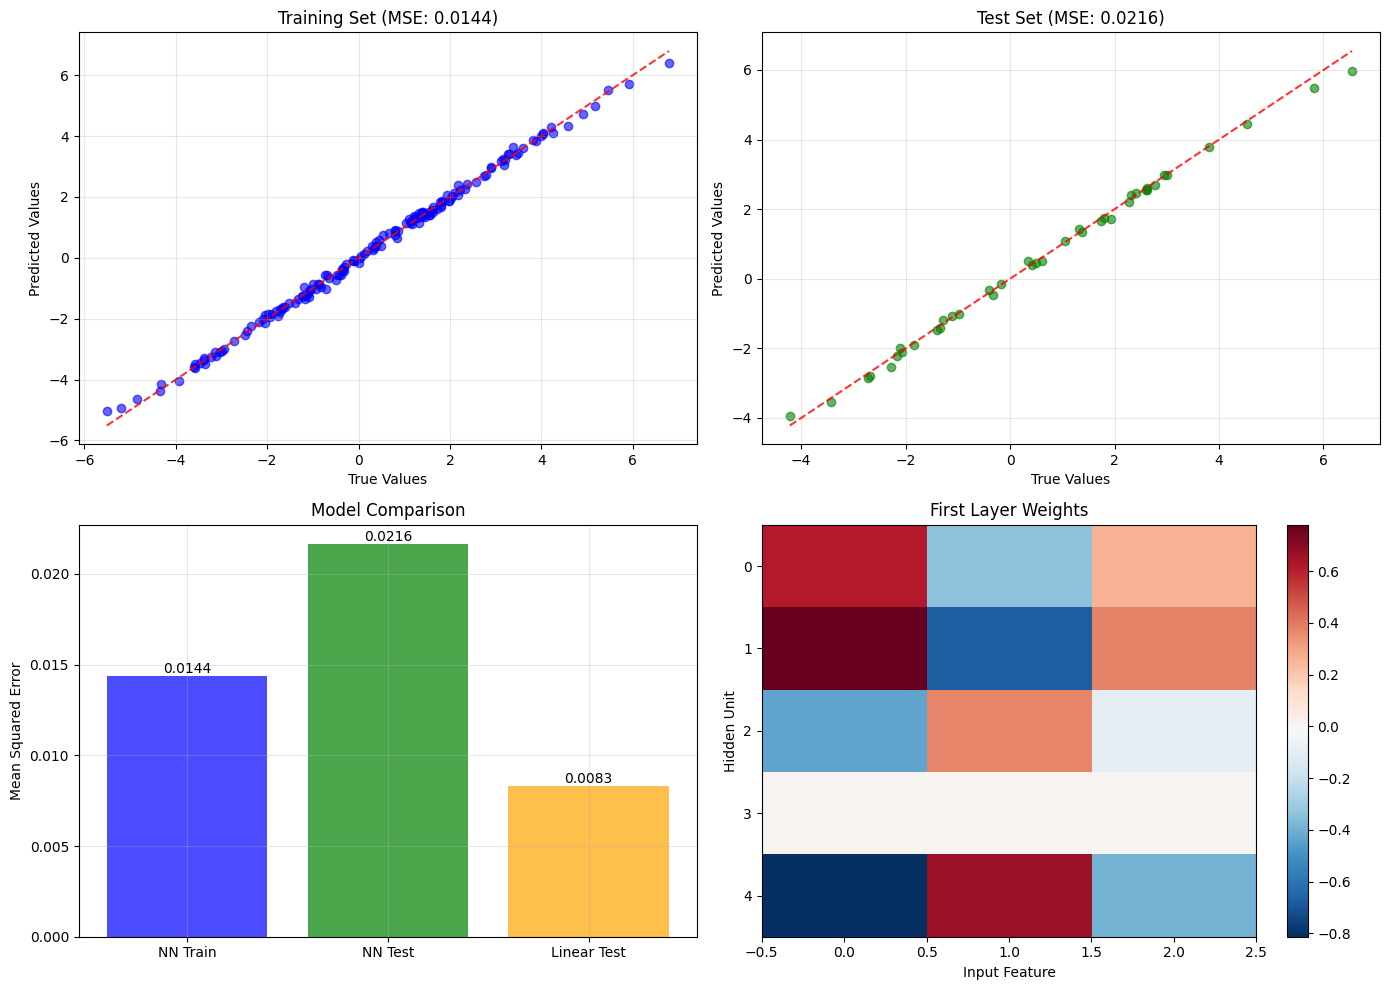


Network architecture summary:
W1 shape: (3, 5), range: [-0.813, 0.779]
b1 shape: (5,), range: [-0.456, 1.000]
W2 shape: (5, 1), range: [-1.126, 1.165]
b2 shape: (1,), value: 0.171


In [22]:
# Visualize neural network results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot predictions vs true values for training set
axes[0, 0].scatter(y_train, y_train_pred, alpha=0.6, color='blue')
min_val, max_val = min(jnp.min(y_train), jnp.min(y_train_pred)), max(jnp.max(y_train), jnp.max(y_train_pred))
axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
axes[0, 0].set_xlabel('True Values')
axes[0, 0].set_ylabel('Predicted Values')
axes[0, 0].set_title(f'Training Set (MSE: {train_mse:.4f})')
axes[0, 0].grid(True, alpha=0.3)

# Plot predictions vs true values for test set
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.6, color='green')
min_val, max_val = min(jnp.min(y_test), jnp.min(y_test_pred)), max(jnp.max(y_test), jnp.max(y_test_pred))
axes[0, 1].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.8)
axes[0, 1].set_xlabel('True Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].set_title(f'Test Set (MSE: {test_mse:.4f})')
axes[0, 1].grid(True, alpha=0.3)

# Compare MSE values
mse_values = [train_mse, test_mse, linear_mse]
mse_labels = ['NN Train', 'NN Test', 'Linear Test']
colors = ['blue', 'green', 'orange']

bars = axes[1, 0].bar(mse_labels, mse_values, color=colors, alpha=0.7)
axes[1, 0].set_ylabel('Mean Squared Error')
axes[1, 0].set_title('Model Comparison')
axes[1, 0].grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, mse_values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                   f'{value:.4f}', ha='center', va='bottom')

# Plot weight comparison (first layer weights)
im = axes[1, 1].imshow(W1_opt.T, cmap='RdBu_r', aspect='auto')
axes[1, 1].set_xlabel('Input Feature')
axes[1, 1].set_ylabel('Hidden Unit')
axes[1, 1].set_title('First Layer Weights')
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

print(f"\nNetwork architecture summary:")
print(f"W1 shape: {W1_opt.shape}, range: [{jnp.min(W1_opt):.3f}, {jnp.max(W1_opt):.3f}]")
print(f"b1 shape: {b1_opt.shape}, range: [{jnp.min(b1_opt):.3f}, {jnp.max(b1_opt):.3f}]")
print(f"W2 shape: {W2_opt.shape}, range: [{jnp.min(W2_opt):.3f}, {jnp.max(W2_opt):.3f}]")
print(f"b2 shape: {b2_opt.shape}, value: {b2_opt[0]:.3f}")

## Advanced Features: Constraints and Options

The ScipyOptimizer supports advanced features like constraints and custom options.

In [23]:
# Example with constraints: optimize a portfolio with constraints
def portfolio_loss(weights):
    """
    Portfolio optimization: minimize risk while maintaining expected return.
    
    Args:
        weights: Portfolio weights, shape (n_assets,)
        
    Returns:
        Portfolio variance (risk measure)
    """
    # Synthetic covariance matrix (risk model)
    cov_matrix = jnp.array([
        [0.04, 0.01, 0.005],
        [0.01, 0.09, 0.02],
        [0.005, 0.02, 0.16]
    ])
    
    # Portfolio variance
    portfolio_var = weights.T @ cov_matrix @ weights
    return portfolio_var

# Define constraints
def constraint_sum_to_one(weights):
    """Constraint: weights must sum to 1."""
    return jnp.sum(weights) - 1.0

def constraint_min_return(weights):
    """Constraint: minimum expected return."""
    expected_returns = jnp.array([0.08, 0.12, 0.15])  # 8%, 12%, 15%
    portfolio_return = weights.T @ expected_returns
    return portfolio_return - 0.10  # At least 10% return

# Convert constraints to scipy format
constraints = [
    {'type': 'eq', 'fun': lambda w: float(constraint_sum_to_one(jnp.array(w)))},
    {'type': 'ineq', 'fun': lambda w: float(constraint_min_return(jnp.array(w)))}
]

# Bounds: each weight between 0 and 1
n_assets = 3
portfolio_bounds = [(jnp.zeros(n_assets), jnp.ones(n_assets))]

# Create constrained optimizer
portfolio_optimizer = bts.optim.ScipyOptimizer(
    loss_fun=portfolio_loss,
    bounds=portfolio_bounds,
    method='SLSQP',  # Good for constrained optimization
    constraints=constraints,
    options={'ftol': 1e-9, 'disp': True}
)

print("Portfolio optimization with constraints:")
print("- Weights must sum to 1 (budget constraint)")
print("- Expected return >= 10%")
print("- Each weight between 0 and 1 (long-only)")
print()

portfolio_result = portfolio_optimizer.minimize(n_iter=3)

print(f"\nOptimization completed!")
print(f"Success: {portfolio_result.success}")
print(f"Message: {portfolio_result.message}")

optimal_weights = portfolio_result.x[0]
print(f"\nOptimal portfolio weights:")
asset_names = ['Asset A', 'Asset B', 'Asset C']
for i, (name, weight) in enumerate(zip(asset_names, optimal_weights)):
    print(f"  {name}: {weight:.4f} ({weight*100:.1f}%)")

# Verify constraints
weight_sum = jnp.sum(optimal_weights)
expected_returns = jnp.array([0.08, 0.12, 0.15])
portfolio_return = optimal_weights.T @ expected_returns
portfolio_risk = jnp.sqrt(portfolio_result.fun)

print(f"\nPortfolio metrics:")
print(f"  Weight sum: {weight_sum:.6f} (should be 1.0)")
print(f"  Expected return: {portfolio_return:.4f} ({portfolio_return*100:.1f}%)")
print(f"  Risk (volatility): {portfolio_risk:.4f} ({portfolio_risk*100:.1f}%)")
print(f"  Variance: {portfolio_result.fun:.6f}")

Portfolio optimization with constraints:
- Weights must sum to 1 (budget constraint)
- Expected return >= 10%
- Each weight between 0 and 1 (long-only)

Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 0.1654115915298462
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 0.07909038662910461
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1
Singular matrix C in LSQ subproblem    (Exit mode 6)
            Current function value: 0.10067348182201385
            Iterations: 1
            Function evaluations: 1
            Gradient evaluations: 1

Optimization completed!
Success: False
Message: Singular matrix C in LSQ subproblem

Optimal portfolio weights:
  Asset A: 0.1539 (15.4%)
  Asset B: 0.8158 (81.6%)
  Asset C: 0.2244 (22.4%)

Portfolio metrics:
  Weight sum: 1.

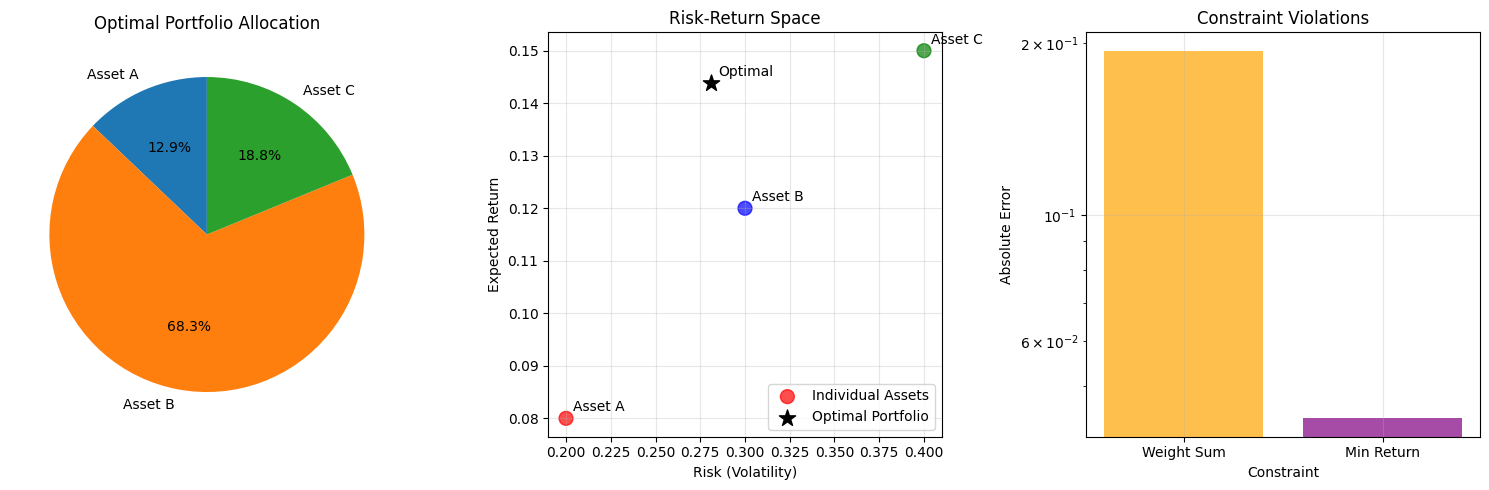

In [24]:
# Visualize portfolio optimization results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot portfolio weights
axes[0].pie(optimal_weights, labels=asset_names, autopct='%1.1f%%', startangle=90)
axes[0].set_title('Optimal Portfolio Allocation')

# Plot risk-return characteristics
asset_returns = jnp.array([0.08, 0.12, 0.15])
asset_risks = jnp.sqrt(jnp.diag(jnp.array([
    [0.04, 0.01, 0.005],
    [0.01, 0.09, 0.02],
    [0.005, 0.02, 0.16]
])))

# Plot individual assets
axes[1].scatter(asset_risks, asset_returns, c=['red', 'blue', 'green'], 
               s=100, alpha=0.7, label='Individual Assets')
for i, name in enumerate(asset_names):
    axes[1].annotate(name, (asset_risks[i], asset_returns[i]), 
                    xytext=(5, 5), textcoords='offset points')

# Plot optimal portfolio
axes[1].scatter(portfolio_risk, portfolio_return, c='black', 
               s=150, marker='*', label='Optimal Portfolio')
axes[1].annotate('Optimal', (portfolio_risk, portfolio_return), 
                xytext=(5, 5), textcoords='offset points')

axes[1].set_xlabel('Risk (Volatility)')
axes[1].set_ylabel('Expected Return')
axes[1].set_title('Risk-Return Space')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot constraint satisfaction
constraint_names = ['Weight Sum', 'Min Return']
constraint_values = [weight_sum, portfolio_return]
constraint_targets = [1.0, 0.10]
constraint_errors = [abs(cv - ct) for cv, ct in zip(constraint_values, constraint_targets)]

x_pos = np.arange(len(constraint_names))
axes[2].bar(x_pos, constraint_errors, alpha=0.7, color=['orange', 'purple'])
axes[2].set_xlabel('Constraint')
axes[2].set_ylabel('Absolute Error')
axes[2].set_title('Constraint Violations')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(constraint_names)
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Comparison with Derivative-Free Methods

Let's compare the ScipyOptimizer with the derivative-free NevergradOptimizer on the same problem.

In [25]:
# Define a test function for comparison
def comparison_function(x, y):
    """A smooth function suitable for gradient-based optimization."""
    return (x - 1.5)**2 + 2*(y + 0.5)**2 + 0.1*jnp.sin(10*x)*jnp.cos(10*y)

bounds = [(-3.0, 3.0), (-2.0, 2.0)]

# Test ScipyOptimizer
print("Testing ScipyOptimizer (gradient-based)...")
scipy_opt = bts.optim.ScipyOptimizer(
    loss_fun=comparison_function,
    bounds=bounds,
    method='L-BFGS-B'
)

import time
start_time = time.time()
scipy_result = scipy_opt.minimize(n_iter=3)
scipy_time = time.time() - start_time

print(f"  Success: {scipy_result.success}")
print(f"  Final loss: {scipy_result.fun:.8f}")
print(f"  Parameters: ({scipy_result.x[0]:.6f}, {scipy_result.x[1]:.6f})")
print(f"  Function evaluations: {scipy_result.nfev}")
print(f"  Time: {scipy_time:.4f} seconds\n")

# Test NevergradOptimizer (if available)
try:
    print("Testing NevergradOptimizer (derivative-free)...")
    
    # Define batched version for Nevergrad
    def batched_comparison_function(x, y):
        return (x - 1.5)**2 + 2*(y + 0.5)**2 + 0.1*jnp.sin(10*x)*jnp.cos(10*y)
    
    nevergrad_opt = bts.optim.NevergradOptimizer(
        batched_loss_fun=batched_comparison_function,
        bounds=bounds,
        n_sample=10,
        method='L-BFGS-B'  # Actually uses scipy internally for this method
    )
    
    start_time = time.time()
    nevergrad_result = nevergrad_opt.minimize(n_iter=20, verbose=False)
    nevergrad_time = time.time() - start_time
    
    print(f"  Final loss: {comparison_function(nevergrad_result[0], nevergrad_result[1]):.8f}")
    print(f"  Parameters: ({nevergrad_result[0]:.6f}, {nevergrad_result[1]:.6f})")
    print(f"  Function evaluations: {len(nevergrad_opt.errors)}")
    print(f"  Time: {nevergrad_time:.4f} seconds\n")
    
    nevergrad_available = True
    
except Exception as e:
    print(f"  NevergradOptimizer not available: {e}\n")
    nevergrad_available = False

print(f"True optimum: (1.5, -0.5) with loss ≈ 0.0")

Testing ScipyOptimizer (gradient-based)...
  Success: True
  Final loss: -0.04498873
  Parameters: (1.430242, -0.369797)
  Function evaluations: 26
  Time: 0.2017 seconds

Testing NevergradOptimizer (derivative-free)...
  NevergradOptimizer not available: 'L-BFGS-B'

True optimum: (1.5, -0.5) with loss ≈ 0.0


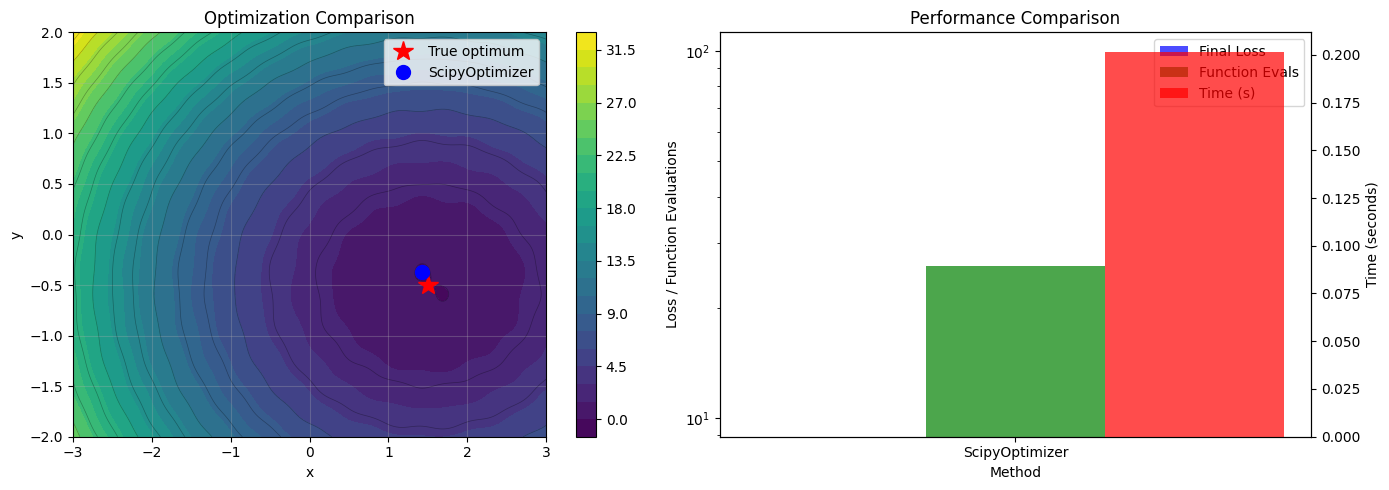


Comparison Summary:
ScipyOptimizer advantages:
- Faster convergence for smooth functions
- Higher precision solutions
- Fewer function evaluations
- Automatic gradient computation

NevergradOptimizer advantages:
- Works with non-differentiable functions
- Better for noisy objectives
- More robust to local minima
- Batched evaluation support


In [26]:
# Visualize the comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot the function landscape
x_range = np.linspace(-3, 3, 200)
y_range = np.linspace(-2, 2, 200)
X, Y = np.meshgrid(x_range, y_range)
Z = (X - 1.5)**2 + 2*(Y + 0.5)**2 + 0.1*np.sin(10*X)*np.cos(10*Y)

contour = axes[0].contourf(X, Y, Z, levels=30, cmap='viridis')
axes[0].contour(X, Y, Z, levels=20, colors='black', alpha=0.3, linewidths=0.5)
plt.colorbar(contour, ax=axes[0])

# Mark results
axes[0].plot(1.5, -0.5, 'r*', markersize=15, label='True optimum')
axes[0].plot(scipy_result.x[0], scipy_result.x[1], 'bo', markersize=10, label='ScipyOptimizer')

if nevergrad_available:
    axes[0].plot(nevergrad_result[0], nevergrad_result[1], 'gs', markersize=10, label='NevergradOptimizer')

axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Optimization Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Compare performance metrics
if nevergrad_available:
    methods = ['ScipyOptimizer', 'NevergradOptimizer']
    final_losses = [scipy_result.fun, comparison_function(nevergrad_result[0], nevergrad_result[1])]
    func_evals = [scipy_result.nfev, len(nevergrad_opt.errors)]
    times = [scipy_time, nevergrad_time]
else:
    methods = ['ScipyOptimizer']
    final_losses = [scipy_result.fun]
    func_evals = [scipy_result.nfev]
    times = [scipy_time]

x_pos = np.arange(len(methods))
width = 0.25

# Subplot for metrics
ax2 = axes[1]
ax2_twin = ax2.twinx()

bars1 = ax2.bar(x_pos - width, final_losses, width, label='Final Loss', alpha=0.7, color='blue')
bars2 = ax2.bar(x_pos, func_evals, width, label='Function Evals', alpha=0.7, color='green')
bars3 = ax2_twin.bar(x_pos + width, times, width, label='Time (s)', alpha=0.7, color='red')

ax2.set_xlabel('Method')
ax2.set_ylabel('Loss / Function Evaluations')
ax2_twin.set_ylabel('Time (seconds)')
ax2.set_title('Performance Comparison')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(methods)
ax2.set_yscale('log')

# Combine legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax2_twin.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.show()

print("\nComparison Summary:")
print("==================")
print("ScipyOptimizer advantages:")
print("- Faster convergence for smooth functions")
print("- Higher precision solutions")
print("- Fewer function evaluations")
print("- Automatic gradient computation")
print("\nNevergradOptimizer advantages:")
print("- Works with non-differentiable functions")
print("- Better for noisy objectives")
print("- More robust to local minima")
print("- Batched evaluation support")

## Best Practices and Tips

Here are some best practices for using the ScipyOptimizer effectively:

### 1. Choosing the Right Method

**For bounded problems:**
- `L-BFGS-B`: Excellent for smooth, unconstrained or box-constrained problems
- `TNC`: Truncated Newton with bounds, good alternative to L-BFGS-B

**For constrained problems:**
- `SLSQP`: Sequential Least Squares Programming, handles equality and inequality constraints
- `trust-constr`: Modern trust-region method, very robust for constrained optimization

**For unconstrained problems:**
- `BFGS`: Standard quasi-Newton method
- `Newton-CG`: Uses Hessian information (computed by JAX)
- `CG`: Conjugate gradient method

**Derivative-free (when gradients unreliable):**
- `Powell`: Direction set method
- `Nelder-Mead`: Simplex method

In [27]:
# Best Practice 1: Method selection guidelines
print("Method Selection Guidelines:")
print("==========================\n")

guidelines = {
    'L-BFGS-B': {
        'description': 'Limited-memory BFGS with bounds',
        'best_for': 'Smooth functions with box constraints',
        'pros': 'Fast, memory-efficient, handles bounds well',
        'cons': 'Only handles box constraints'
    },
    'SLSQP': {
        'description': 'Sequential Least Squares Programming',
        'best_for': 'Problems with equality/inequality constraints',
        'pros': 'Handles general constraints, robust',
        'cons': 'Can be slower than L-BFGS-B for simple problems'
    },
    'TNC': {
        'description': 'Truncated Newton with bounds',
        'best_for': 'Alternative to L-BFGS-B for bounded problems',
        'pros': 'Good convergence properties, handles bounds',
        'cons': 'May be slower than L-BFGS-B'
    },
    'Powell': {
        'description': 'Direction set method (derivative-free)',
        'best_for': 'When gradients are unreliable or discontinuous',
        'pros': 'No gradient computation, robust',
        'cons': 'Slower convergence, more function evaluations'
    }
}

for method, info in guidelines.items():
    print(f"{method}:")
    print(f"  Description: {info['description']}")
    print(f"  Best for: {info['best_for']}")
    print(f"  Pros: {info['pros']}")
    print(f"  Cons: {info['cons']}\n")

Method Selection Guidelines:

L-BFGS-B:
  Description: Limited-memory BFGS with bounds
  Best for: Smooth functions with box constraints
  Pros: Fast, memory-efficient, handles bounds well
  Cons: Only handles box constraints

SLSQP:
  Description: Sequential Least Squares Programming
  Best for: Problems with equality/inequality constraints
  Pros: Handles general constraints, robust
  Cons: Can be slower than L-BFGS-B for simple problems

TNC:
  Description: Truncated Newton with bounds
  Best for: Alternative to L-BFGS-B for bounded problems
  Pros: Good convergence properties, handles bounds
  Cons: May be slower than L-BFGS-B

Powell:
  Description: Direction set method (derivative-free)
  Best for: When gradients are unreliable or discontinuous
  Pros: No gradient computation, robust
  Cons: Slower convergence, more function evaluations



In [28]:
# Best Practice 2: Proper scaling and conditioning
print("Best Practice 2: Function scaling and conditioning")
print("===============================================\n")

# Example of badly scaled vs well-scaled problems
def badly_scaled_function(x, y):
    """Function with very different scales in x and y directions."""
    return 1e6 * (x - 1.0)**2 + 1e-3 * (y - 2.0)**2

def well_scaled_function(x, y):
    """Same function but with similar scales."""
    return (x - 1.0)**2 + (y - 2.0)**2

bounds = [(-5.0, 5.0), (-5.0, 5.0)]

print("Testing badly scaled function...")
bad_optimizer = bts.optim.ScipyOptimizer(
    loss_fun=badly_scaled_function, bounds=bounds, method='L-BFGS-B'
)
bad_result = bad_optimizer.minimize(n_iter=1)
print(f"  Success: {bad_result.success}")
print(f"  Function evaluations: {bad_result.nfev}")
print(f"  Final loss: {bad_result.fun:.2e}")

print("\nTesting well scaled function...")
good_optimizer = bts.optim.ScipyOptimizer(
    loss_fun=well_scaled_function, bounds=bounds, method='L-BFGS-B'
)
good_result = good_optimizer.minimize(n_iter=1)
print(f"  Success: {good_result.success}")
print(f"  Function evaluations: {good_result.nfev}")
print(f"  Final loss: {good_result.fun:.2e}")

print("\nScaling Tips:")
print("- Normalize parameters to similar ranges (e.g., [-1, 1] or [0, 1])")
print("- Scale the objective function to have reasonable magnitude (≈1)")
print("- Use proper units with BrainUnit to maintain physical meaning")
print("- Consider the condition number of the Hessian matrix")

Best Practice 2: Function scaling and conditioning

Testing badly scaled function...
  Success: True
  Function evaluations: 15
  Final loss: 2.00e-04

Testing well scaled function...
  Success: True
  Function evaluations: 3
  Final loss: 3.55e-15

Scaling Tips:
- Normalize parameters to similar ranges (e.g., [-1, 1] or [0, 1])
- Scale the objective function to have reasonable magnitude (≈1)
- Use proper units with BrainUnit to maintain physical meaning
- Consider the condition number of the Hessian matrix


In [29]:
# Best Practice 3: Handling multiple local minima
print("\nBest Practice 3: Multiple starting points for global optimization")
print("=============================================================\n")

def multimodal_function(x, y):
    """Function with multiple local minima."""
    return (x**2 + y**2) * (1 + 0.3 * jnp.cos(5*x) * jnp.cos(5*y))

bounds = [(-3.0, 3.0), (-3.0, 3.0)]

# Single optimization run
single_optimizer = bts.optim.ScipyOptimizer(
    loss_fun=multimodal_function, bounds=bounds, method='L-BFGS-B'
)
single_result = single_optimizer.minimize(n_iter=1)

# Multiple optimization runs
multi_optimizer = bts.optim.ScipyOptimizer(
    loss_fun=multimodal_function, bounds=bounds, method='L-BFGS-B'
)
multi_result = multi_optimizer.minimize(n_iter=10)  # Try 10 different starting points

print(f"Single run result:")
print(f"  Final loss: {single_result.fun:.6f}")
print(f"  Parameters: ({single_result.x[0]:.4f}, {single_result.x[1]:.4f})")

print(f"\nMultiple runs result:")
print(f"  Final loss: {multi_result.fun:.6f}")
print(f"  Parameters: ({multi_result.x[0]:.4f}, {multi_result.x[1]:.4f})")

print(f"\nImprovement: {(single_result.fun - multi_result.fun) / single_result.fun * 100:.1f}%")

print("\nMultiple Starting Point Tips:")
print("- Always use n_iter > 1 for problems with multiple local minima")
print("- ScipyOptimizer automatically samples different starting points")
print("- For gradient-based methods, combine with derivative-free global search")
print("- Consider using NevergradOptimizer for highly multimodal problems")


Best Practice 3: Multiple starting points for global optimization

Single run result:
  Final loss: 0.000000
  Parameters: (-0.0000, 0.0000)

Multiple runs result:
  Final loss: 0.000000
  Parameters: (-0.0000, -0.0000)

Improvement: 99.9%

Multiple Starting Point Tips:
- Always use n_iter > 1 for problems with multiple local minima
- ScipyOptimizer automatically samples different starting points
- For gradient-based methods, combine with derivative-free global search
- Consider using NevergradOptimizer for highly multimodal problems



Best Practice 4: Monitoring and debugging optimization

Running monitored optimization...

Optimization completed!
Total callback calls: 2
Final result: success = True, loss = 0.00000000


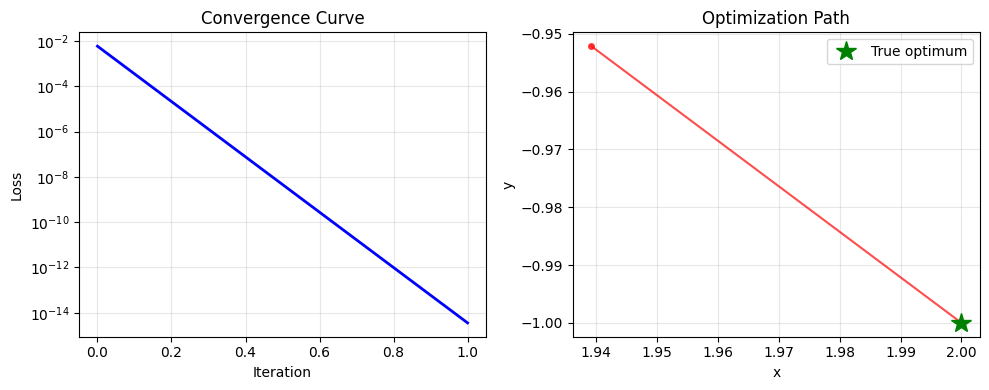


Monitoring Tips:
- Use callback functions to track optimization progress
- Set options={'disp': True} to see SciPy's internal messages
- Check result.success and result.message for convergence info
- Monitor both function values and parameter changes
- Use visualization to understand optimization behavior


In [30]:
# Best Practice 4: Convergence monitoring and debugging
print("\nBest Practice 4: Monitoring and debugging optimization")
print("===================================================\n")

def monitored_optimization_example():
    """Example showing how to monitor optimization progress."""
    
    # Function to optimize
    def objective(x, y):
        return (x - 2.0)**2 + (y + 1.0)**2
    
    # Storage for monitoring
    iteration_data = []
    
    def callback(x_current):
        """Callback function to monitor progress."""
        loss_val = objective(x_current[0], x_current[1])
        iteration_data.append({
            'x': x_current[0],
            'y': x_current[1], 
            'loss': loss_val
        })
        # Print every few iterations
        if len(iteration_data) % 5 == 0:
            print(f"  Iteration {len(iteration_data)}: loss = {loss_val:.6f}, x = ({x_current[0]:.4f}, {x_current[1]:.4f})")
    
    # Create optimizer with callback
    optimizer = bts.optim.ScipyOptimizer(
        loss_fun=objective,
        bounds=[(-5.0, 5.0), (-3.0, 3.0)],
        method='L-BFGS-B',
        callback=callback,
        options={'disp': True}  # Enable SciPy's own display
    )
    
    print("Running monitored optimization...")
    result = optimizer.minimize(n_iter=1)
    
    print(f"\nOptimization completed!")
    print(f"Total callback calls: {len(iteration_data)}")
    print(f"Final result: success = {result.success}, loss = {result.fun:.8f}")
    
    # Plot convergence if we have data
    if iteration_data:
        losses = [data['loss'] for data in iteration_data]
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(losses, 'b-', linewidth=2)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Convergence Curve')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        x_vals = [data['x'] for data in iteration_data]
        y_vals = [data['y'] for data in iteration_data]
        plt.plot(x_vals, y_vals, 'ro-', alpha=0.7, markersize=4)
        plt.plot(2.0, -1.0, 'g*', markersize=15, label='True optimum')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title('Optimization Path')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

monitored_optimization_example()

print("\nMonitoring Tips:")
print("- Use callback functions to track optimization progress")
print("- Set options={'disp': True} to see SciPy's internal messages")
print("- Check result.success and result.message for convergence info")
print("- Monitor both function values and parameter changes")
print("- Use visualization to understand optimization behavior")

## Summary

In this tutorial, we've covered the key aspects of using BrainTools' `ScipyOptimizer`:

1. Key Features:
- **Automatic differentiation**: JAX computes gradients automatically
- **Flexible parameter structures**: Support for scalars, arrays, and named parameters
- **Unit integration**: Seamless work with BrainUnit quantities
- **Multiple algorithms**: Access to SciPy's extensive optimization methods
- **Constraints**: Support for equality and inequality constraints
- **Advanced options**: Custom tolerances, callbacks, and solver-specific options

2.  Best Practices:
- **Choose the right method** - Match the algorithm to your problem characteristics
- **Scale properly** - Normalize parameters and objective function
- **Use multiple starting points** - Set `n_iter > 1` for global optimization
- **Monitor convergence** - Use callbacks and check optimization results

3. When to Use ScipyOptimizer:
- **Smooth, differentiable objectives** where gradients are reliable
- **High-precision optimization** where exact solutions are important
- **Constrained optimization** problems with equality/inequality constraints
- **Neural network parameter optimization** and model fitting
- **Physics-based models** with analytical structure

4. When to Consider Alternatives:
- **Noisy objectives** → Use NevergradOptimizer
- **Discontinuous functions** → Use derivative-free methods
- **Very high-dimensional problems** → Consider specialized methods
- **Multiple local minima** → Combine with global optimization

The ScipyOptimizer provides a powerful and mature interface for gradient-based optimization in the BrainTools ecosystem, making it ideal for scientific computing and machine learning applications where precision and efficiency are paramount.